In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import pickle
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('cleaned_df.pkl')

In [3]:
df.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Target
0,1532698,11,11,648,107.181818,196.245162,976,0,179.0,364.186491,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,0
3,1745392,11,11,648,107.181818,196.245162,976,0,179.0,364.186491,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,0
7,1566324,11,11,648,107.181818,196.245162,976,0,179.0,364.186491,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,0
12,1611060,13,11,648,90.692308,183.612538,976,0,179.0,364.186491,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,0
16,1662832,11,11,648,107.181818,196.245162,976,0,179.0,364.186491,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,0


In [4]:
df['Label'].unique()

array(['Benign', 'Brute Force', 'SQL Injection'], dtype=object)

## Benign vs. Rest

In [5]:
df1 = df.copy()

In [6]:
def set_target(my_str):
    if my_str == 'Benign':
        return 1 
    elif my_str == 'Brute Force':
        return 0
    elif my_str == 'SQL Injection':
        return 0

df1['Target'] = df1['Label'].apply(set_target)

## Splitting Data

In [7]:
y = df1['Target'] 
y1 = y.copy()
df1.drop(columns=['Label', 'Target'], inplace=True) 
X = df1
X, X_test, y, y_test = train_test_split(X, y1, test_size=0.20, random_state=91, stratify = y1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=95, stratify = y)

In [8]:
benign_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
benign_classifier.fit(X_train, y_train)
benign_y_val = benign_classifier.predict(X_val)
print(classification_report(y_val, benign_y_val))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       1.00      1.00      1.00    168386

    accuracy                           1.00    168474
   macro avg       1.00      0.98      0.99    168474
weighted avg       1.00      1.00      1.00    168474



In [10]:
y_tuned = (benign_classifier.predict_proba(X_val)[:,1] > 0.5)
print(classification_report(y_val, y_tuned))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       1.00      1.00      1.00    168386

    accuracy                           1.00    168474
   macro avg       1.00      0.98      0.99    168474
weighted avg       1.00      1.00      1.00    168474



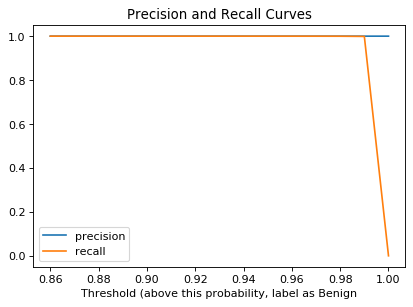

In [9]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, benign_classifier.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Benign');
plt.title('Precision and Recall Curves');

## BruteForce vs. Rest

In [11]:
df2 = df.copy()
def set_target(my_str):
    if my_str == 'Benign':
        return 0
    elif my_str == 'Brute Force':
        return 1
    elif my_str == 'SQL Injection':
        return 0

df2['Target'] = df2['Label'].apply(set_target)

y = df2['Target'] 
y1 = y.copy()
df2.drop(columns=['Label', 'Target'], inplace=True) 
X = df2
X, X_test, y, y_test = train_test_split(X, y1, test_size=0.20, random_state=91, stratify = y1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=95, stratify = y)

In [12]:
brute_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
brute_classifier.fit(X_train, y_train)
brute_y_val = brute_classifier.predict(X_val) 
print(classification_report(y_val, brute_y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    168398
           1       1.00      0.92      0.96        76

    accuracy                           1.00    168474
   macro avg       1.00      0.96      0.98    168474
weighted avg       1.00      1.00      1.00    168474



In [31]:
y_tuned = (brute_classifier.predict_proba(X_val)[:,1] > 0.05)
print(classification_report(y_val, y_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    168398
           1       0.89      0.96      0.92        76

    accuracy                           1.00    168474
   macro avg       0.95      0.98      0.96    168474
weighted avg       1.00      1.00      1.00    168474



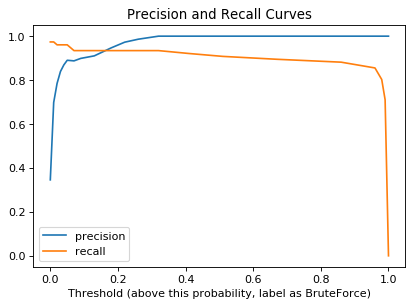

In [13]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, brute_classifier.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as BruteForce)');
plt.title('Precision and Recall Curves');

## SQL Injection vs. Rest

In [34]:
df3 = df.copy()
def set_target(my_str):
    if my_str == 'Benign':
        return 0
    elif my_str == 'Brute Force':
        return 0
    elif my_str == 'SQL Injection':
        return 1

df3['Target'] = df3['Label'].apply(set_target)

y = df3['Target'] 
y1 = y.copy()
df3.drop(columns=['Label', 'Target'], inplace=True) 
X = df3
X, X_test, y, y_test = train_test_split(X, y1, test_size=0.20, random_state=91, stratify = y1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=95, stratify = y)

In [35]:
sql_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
sql_classifier.fit(X_train, y_train)
sql_y_val = sql_classifier.predict(X_val) 
print(classification_report(y_val, sql_y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    168463
           1       1.00      0.45      0.62        11

    accuracy                           1.00    168474
   macro avg       1.00      0.73      0.81    168474
weighted avg       1.00      1.00      1.00    168474



In [47]:
y_tuned = (sql_classifier.predict_proba(X_val)[:,1] > 0.2)
print(classification_report(y_val, y_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    168463
           1       0.79      1.00      0.88        11

    accuracy                           1.00    168474
   macro avg       0.89      1.00      0.94    168474
weighted avg       1.00      1.00      1.00    168474



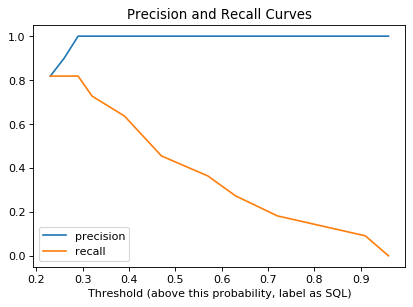

In [46]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, sql_classifier.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as SQL)');
plt.title('Precision and Recall Curves');
#plt.xlim([0, 1])